In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from ipynb.fs.full.UtilFunctions import format_season

In [45]:
def pre_process(seasons):
    df = None
    for season in seasons:
        columns_to_drop = ['index', 'TRB', 'ORB', 'DRB', 'AST', '3PAr', '3P', 'BLK', 'STL', '2P', 'FG', 
                                  'VORP', 'OWS', 'DWS', 'WS', 'FT', 'OBPM', 'DBPM', 'FG%', 
                                  'G', 'GS', 'TOV']
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if season > 1997:
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])
            columns_to_drop.append(['HeavesAttempted', 'Heaves', 'Dunks'])
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=columns_to_drop, inplace=True)
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    return df

In [3]:
def random_forest_classify(X_train, y_train):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 20)},
                                 n_iter = 5, cv = 5, random_state=42)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

In [4]:
def plot_feature_importances(importances, estimators, features):
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    #std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.bar(fi.index, fi)
    ax.tick_params('x', labelrotation=90)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")

## Pre-processing - gathering data from the last 6 seasons

In [5]:
df = pre_process(range(2017, 2023))

## Feature selection, splitting into training/testing

In [6]:
features = df.loc[:, ~df.columns.isin(["Player", "Pos", "Tm"])]
target = df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

## Randomly select better parameters for Random Forest and fit the data

In [7]:
rf = random_forest_classify(X_train, y_train)

In [8]:
y_pred = rf.predict(X_test)

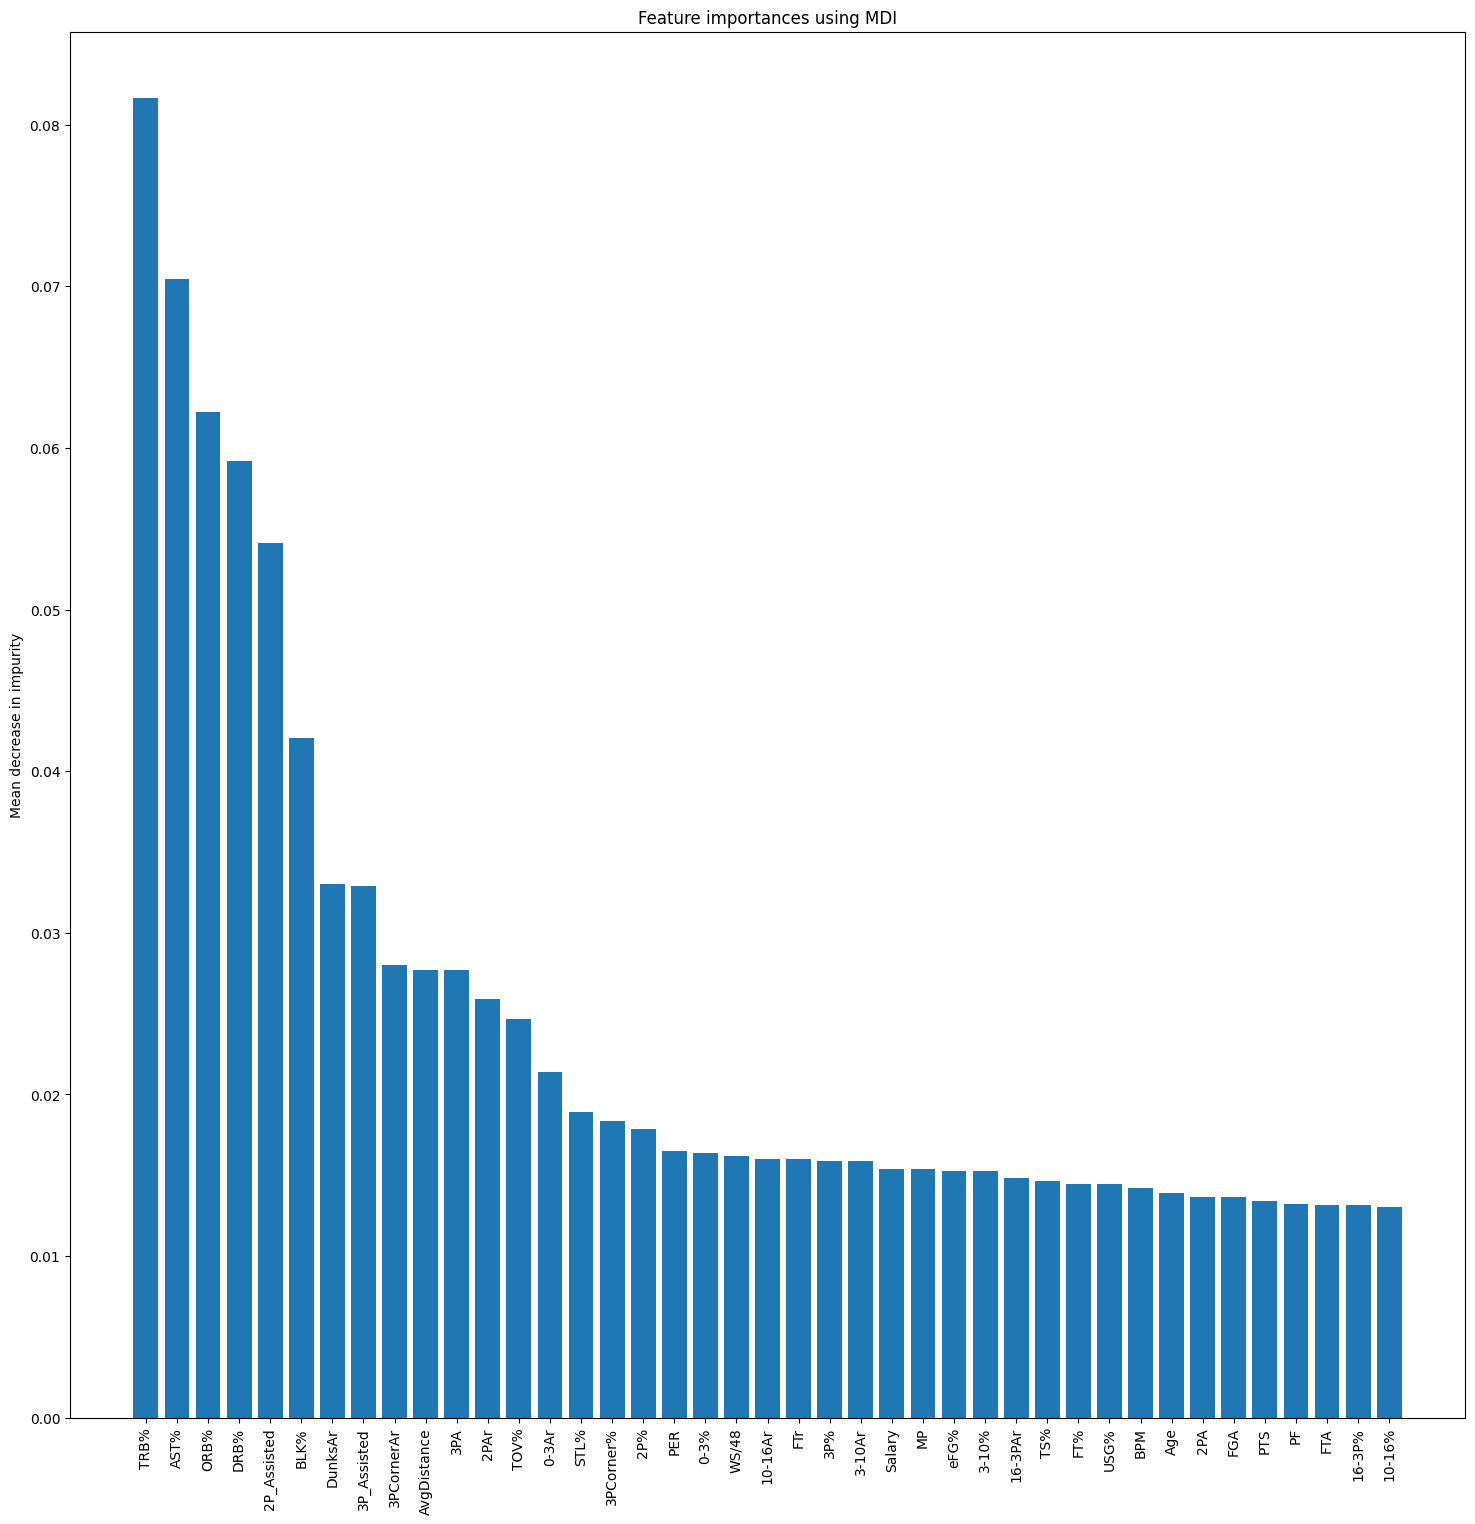

In [9]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in df.columns if c not in ['Player', 'Pos', 'Tm']])

In [10]:
fi = rf.feature_importances_

## Evaluating Random Forest results with Confusion Matrix and accuracy score

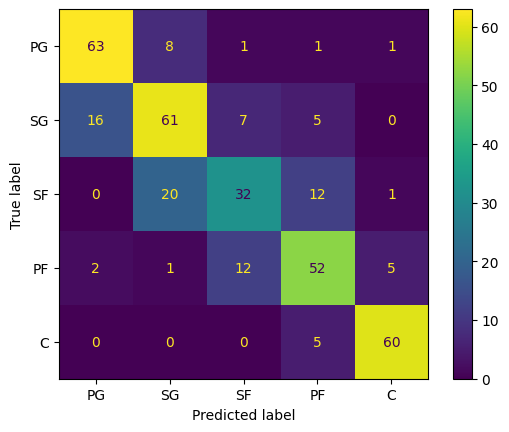

In [11]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [12]:
accuracy_score(y_test, y_pred)

0.7342465753424657

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.90      0.92      0.91        65
          PF       0.69      0.72      0.71        72
          PG       0.78      0.85      0.81        74
          SF       0.62      0.49      0.55        65
          SG       0.68      0.69      0.68        89

    accuracy                           0.73       365
   macro avg       0.73      0.73      0.73       365
weighted avg       0.73      0.73      0.73       365



## Visualize trees from random forest with Graphviz

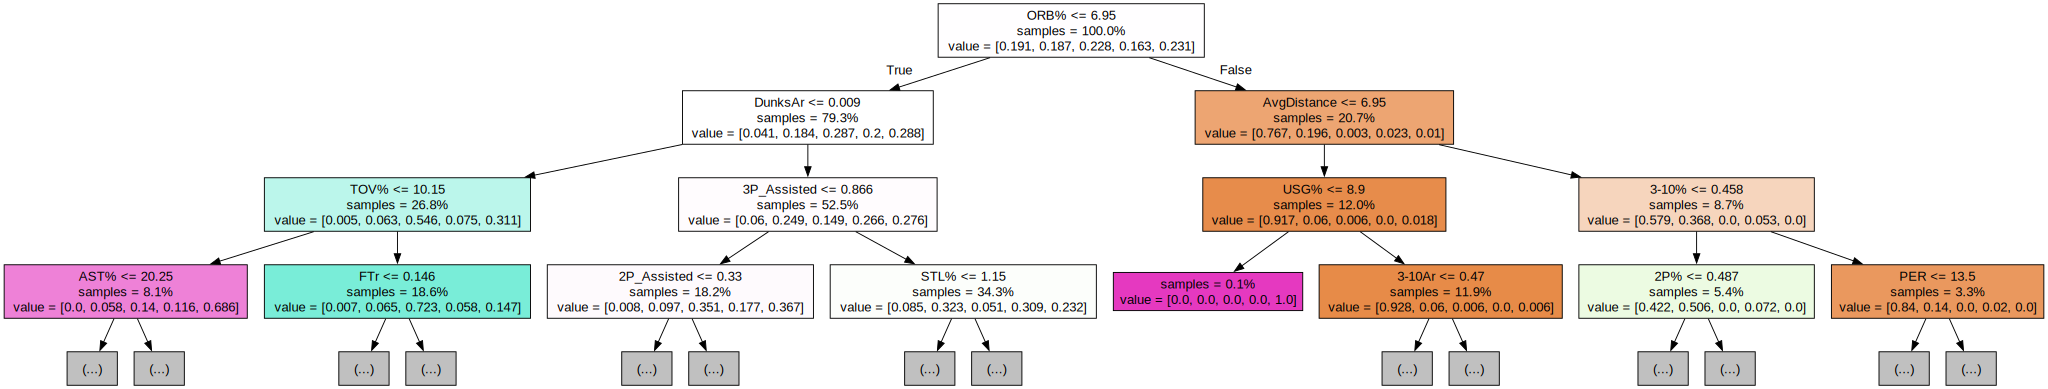

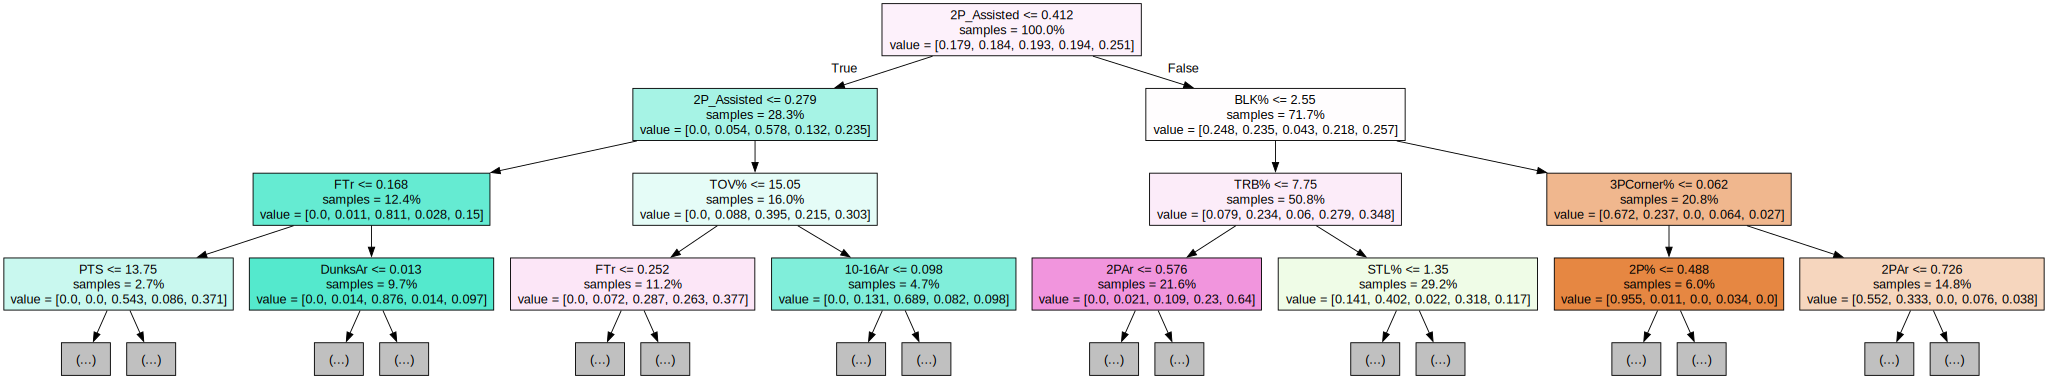

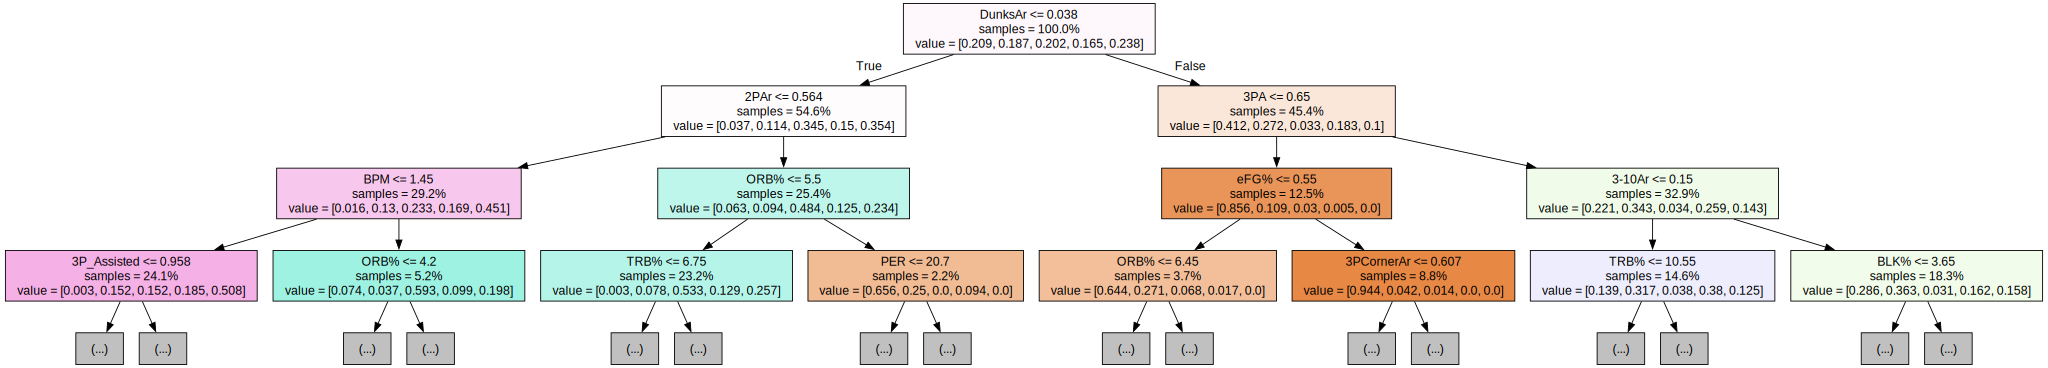

In [14]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, but with data from the early 2000s

## Feature selection, splitting into training/testing

In [15]:
old_df = pre_process(range(2000, 2006))

In [16]:
features = old_df.loc[:, ~old_df.columns.isin(["Player", "Pos", "Tm"])]
target = old_df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

## Randomly select better parameters for Random Forest and fit the data

In [17]:
rf = random_forest_classify(X_train, y_train)

In [18]:
y_pred = rf.predict(X_test)

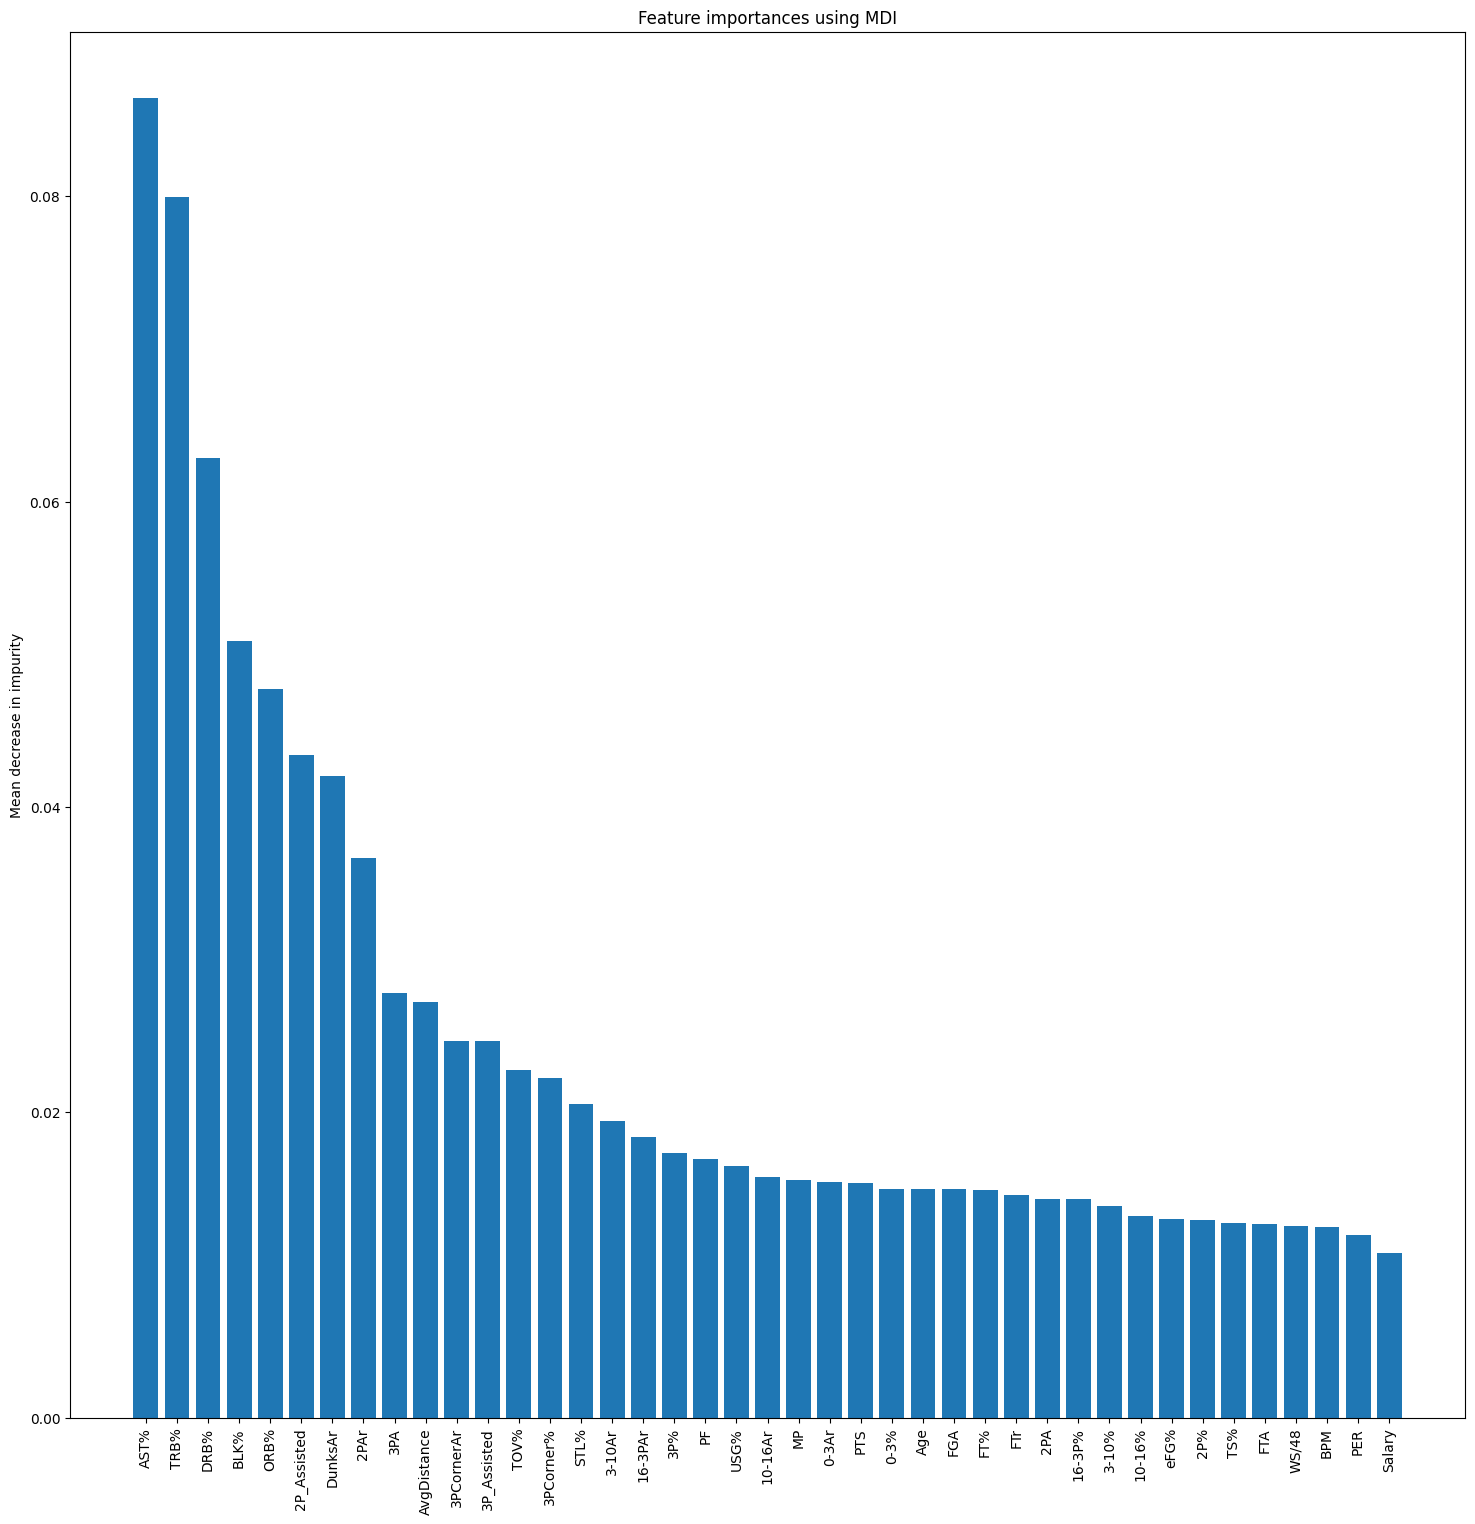

In [19]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in df.columns if c not in ['Player', 'Pos', 'Tm']])

Text(0.5, 0, 'Feature')

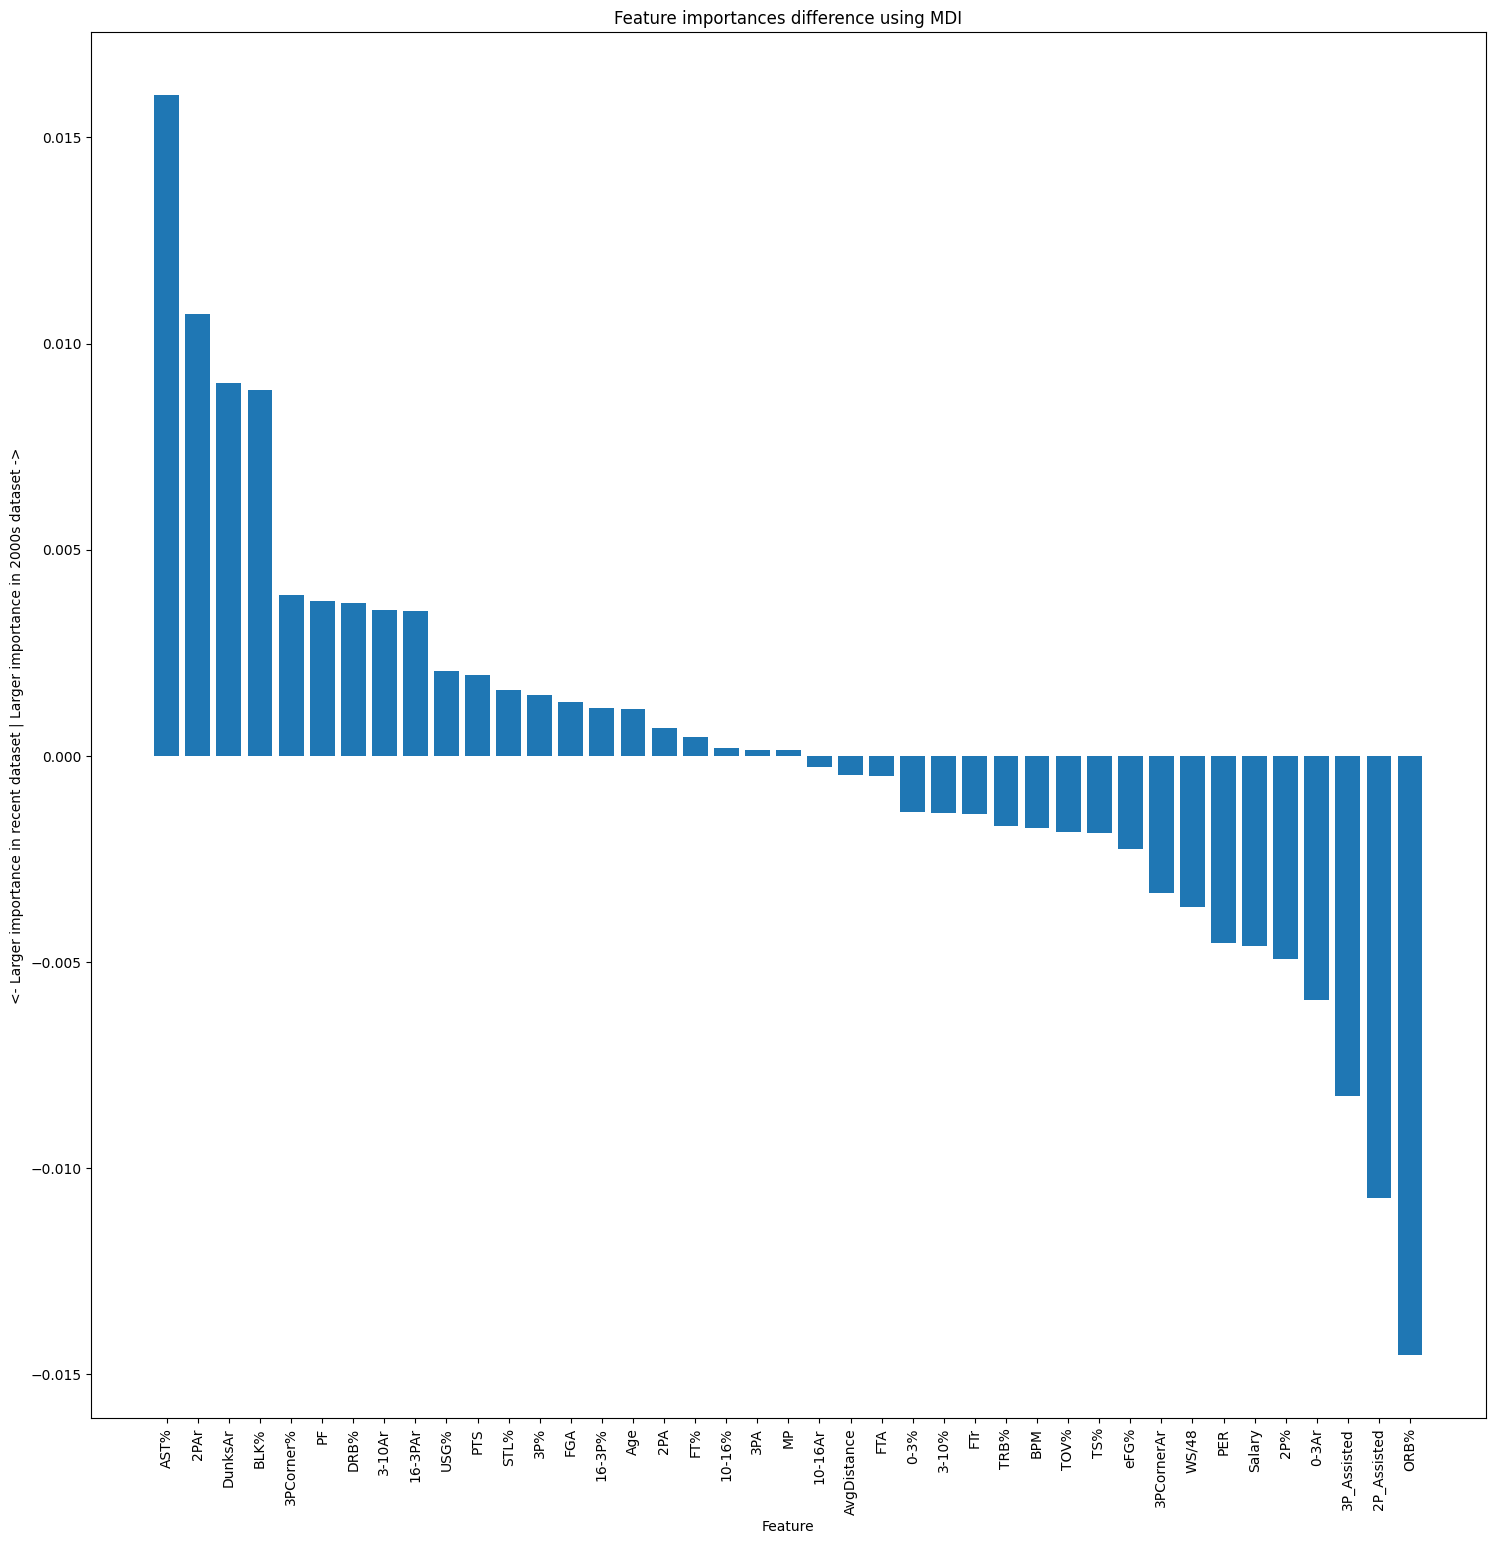

In [20]:
fis = pd.Series(rf.feature_importances_ - fi, index=[c for c in df.columns if c not in ['Player', 'Pos', 'Tm']]).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(18, 18))
ax.bar(fis.index, fis)
ax.tick_params('x', labelrotation=90)
ax.set_title("Feature importances difference using MDI")
ax.set_ylabel("<- Larger importance in recent dataset | Larger importance in 2000s dataset ->")
ax.set_xlabel("Feature")

## Evaluating Random Forest results with Confusion Matrix and accuracy score

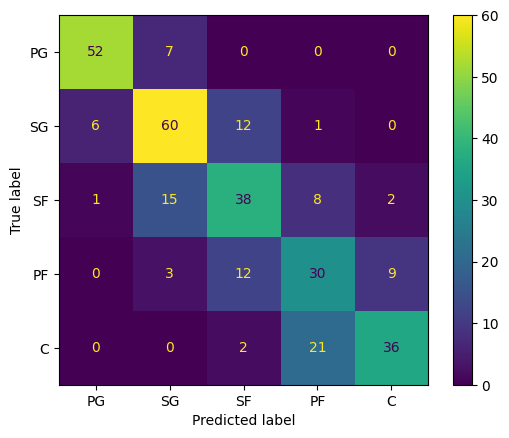

In [21]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [22]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6857142857142857

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.77      0.61      0.68        59
          PF       0.50      0.56      0.53        54
          PG       0.88      0.88      0.88        59
          SF       0.59      0.59      0.59        64
          SG       0.71      0.76      0.73        79

    accuracy                           0.69       315
   macro avg       0.69      0.68      0.68       315
weighted avg       0.69      0.69      0.69       315



## Visualize trees from random forest with Graphviz

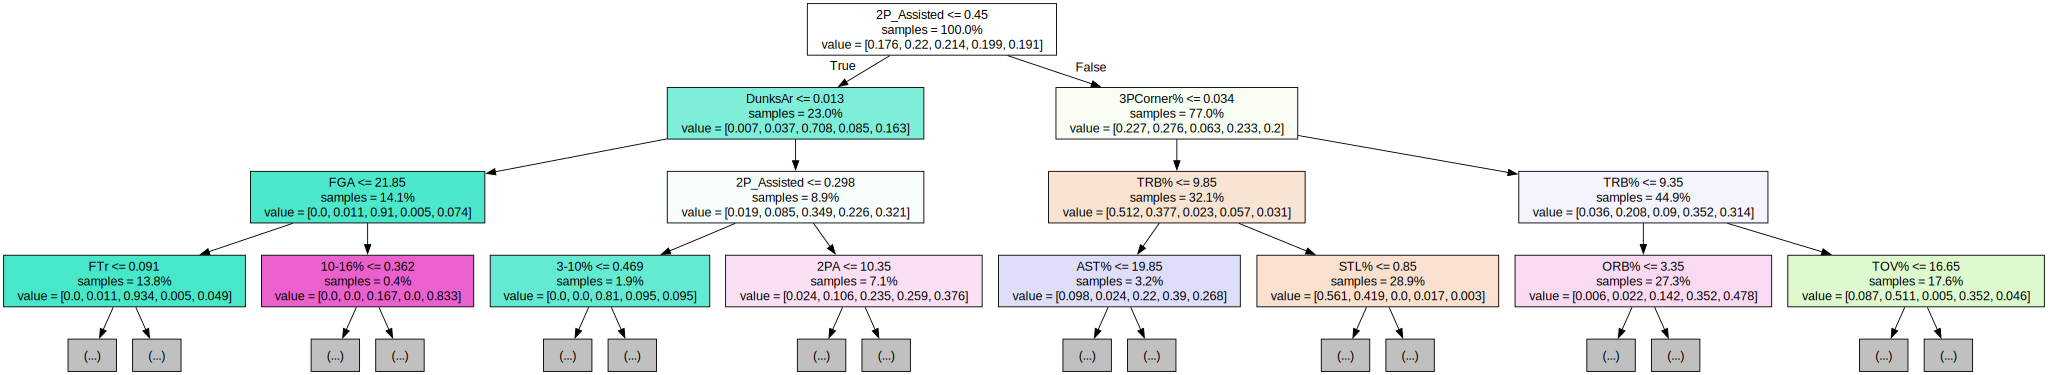

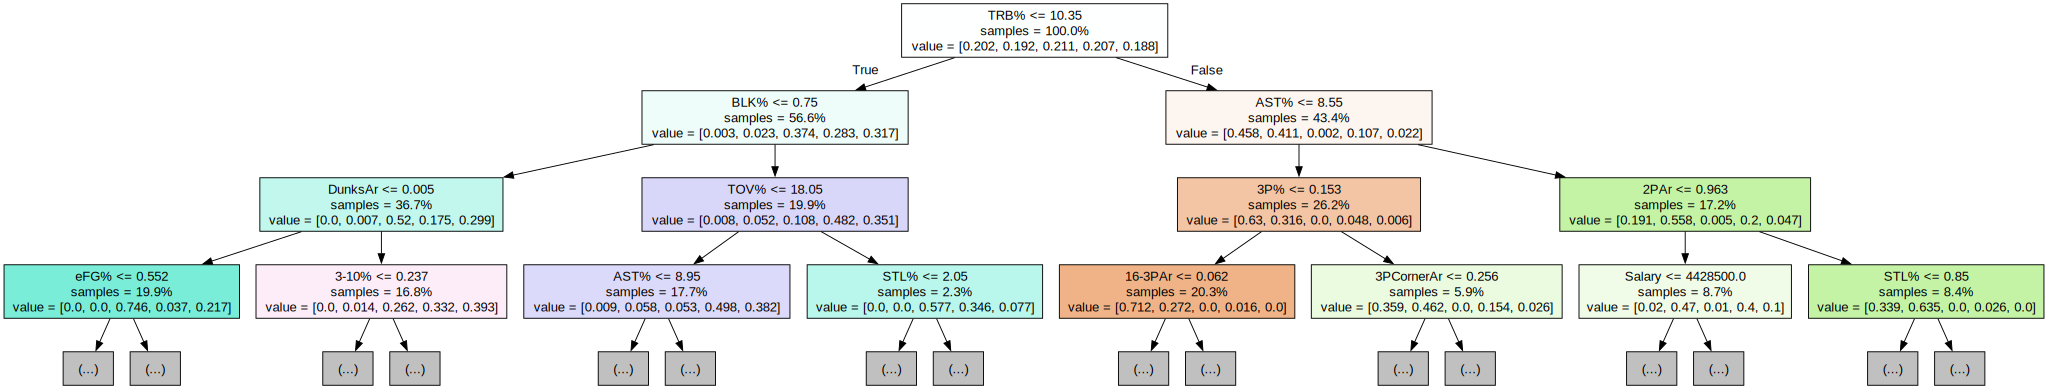

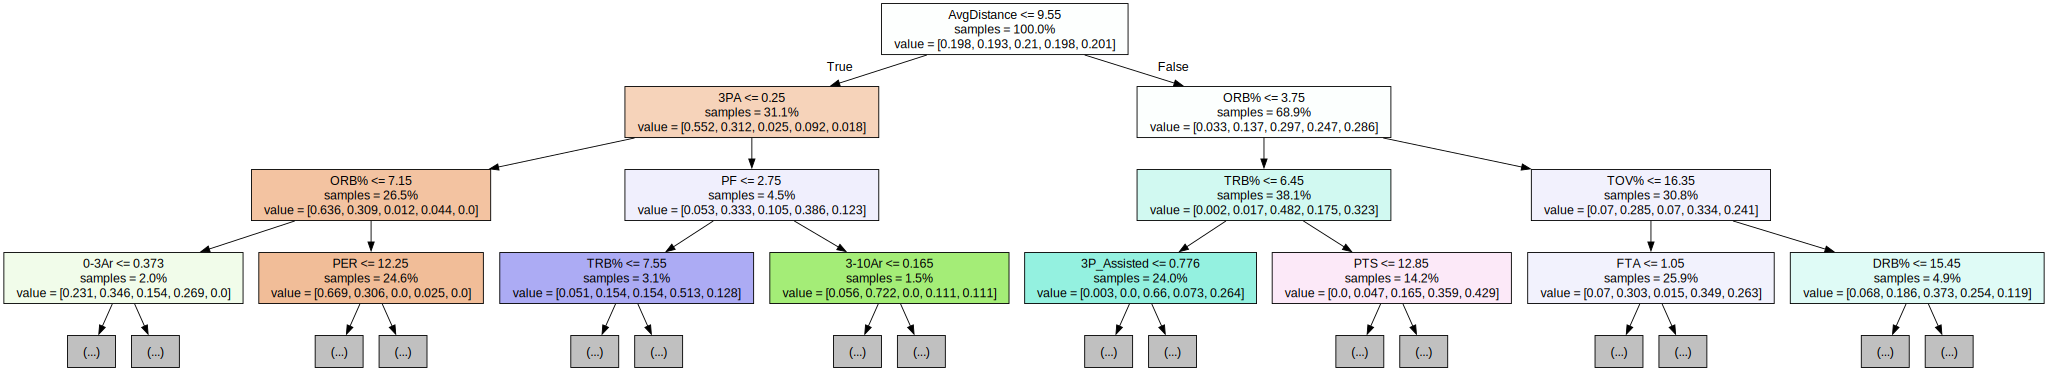

In [24]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, but training with recent seasons and predicting old ones

## Splitting into training/testing

In [25]:
features = df.loc[:, ~df.columns.isin(["Player", "Pos", "Tm"])]
target = df['Pos']

old_features = old_df.loc[:, ~old_df.columns.isin(["Player", "Pos", "Tm"])]
old_target = old_df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)
old_X_train, old_X_test, old_y_train, old_y_test = train_test_split(old_features, old_target, test_size = 0.2, random_state=42)

## Randomly select better parameters for Random Forest and fit the data

In [26]:
rf = random_forest_classify(X_train, y_train)

In [27]:
y_pred = rf.predict(old_X_test)

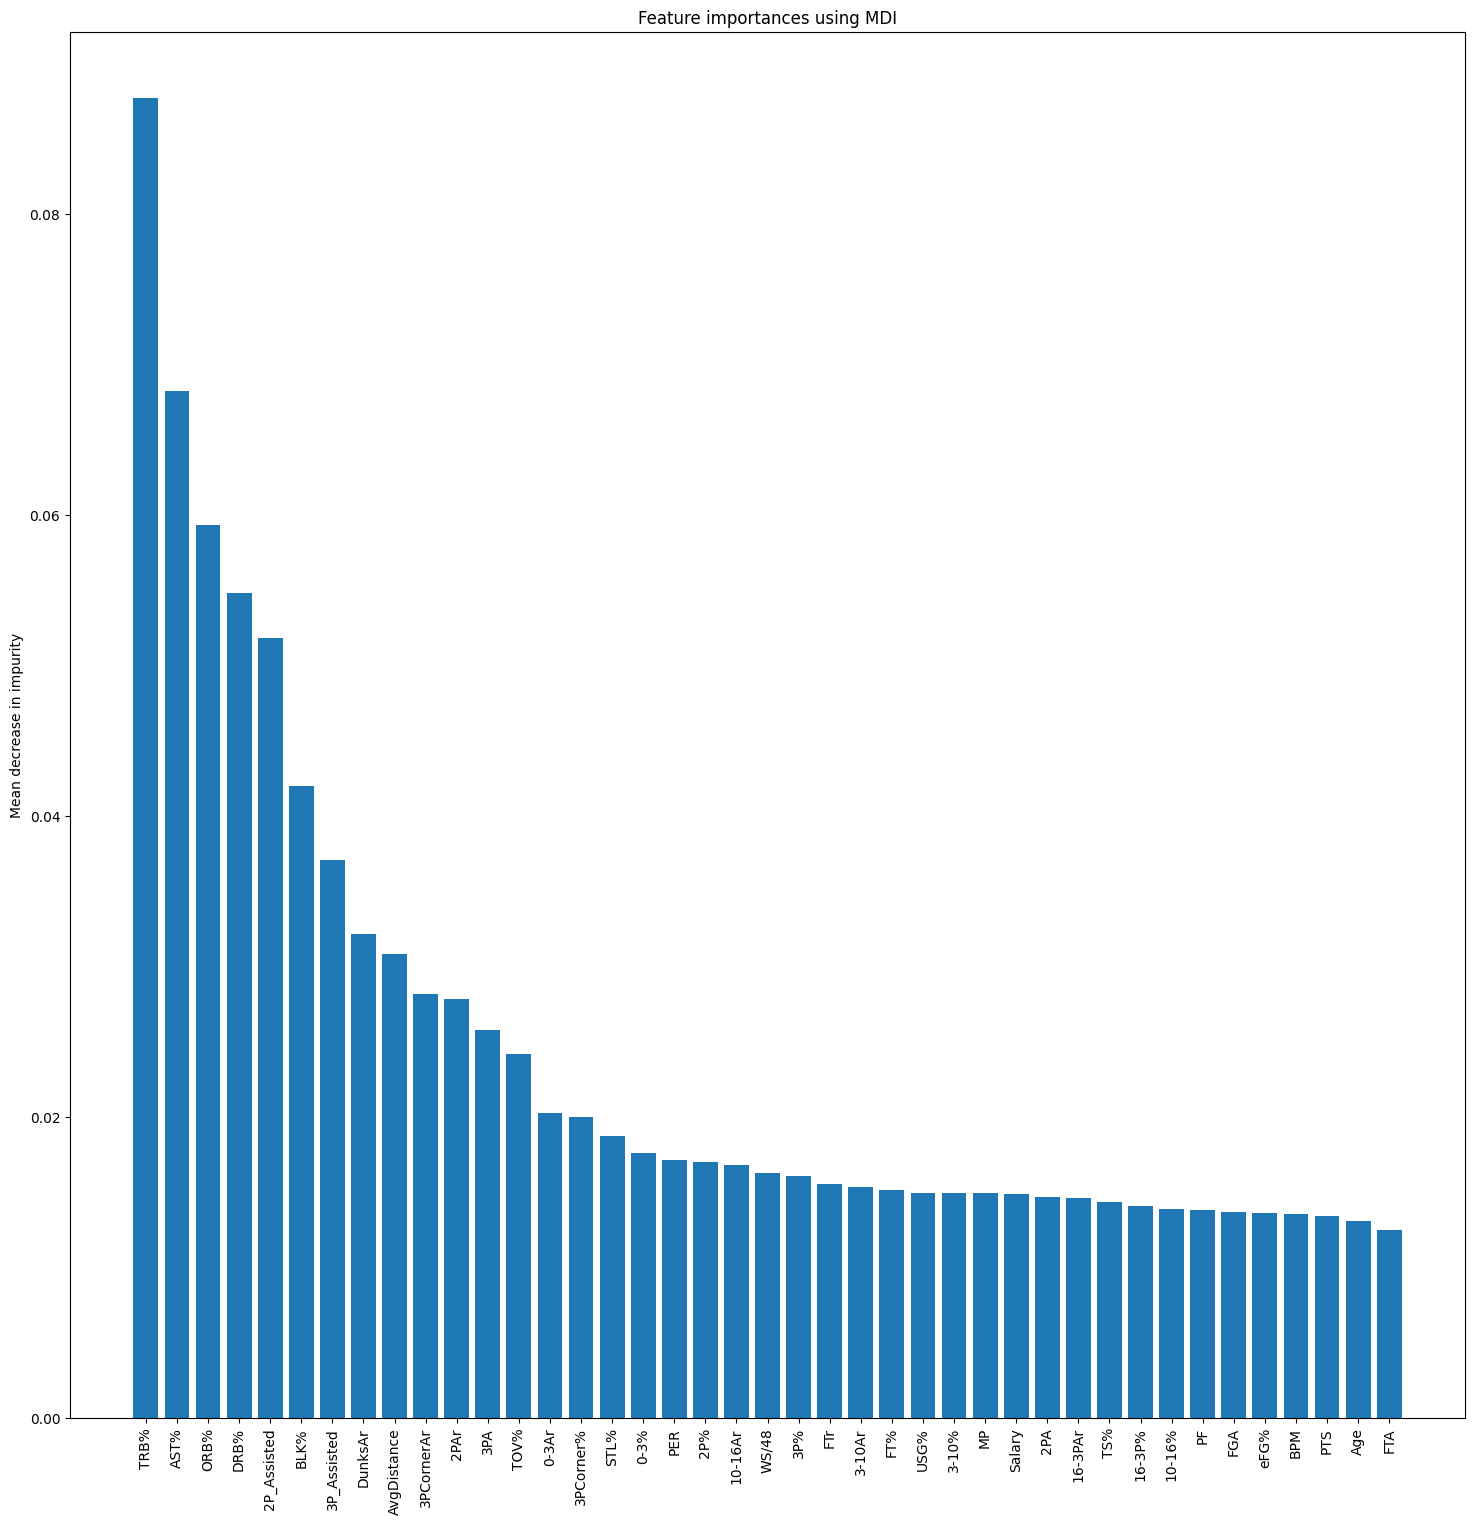

In [28]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in df.columns if c not in ['Player', 'Pos', 'Tm']])

## Evaluating Random Forest results with Confusion Matrix and accuracy score

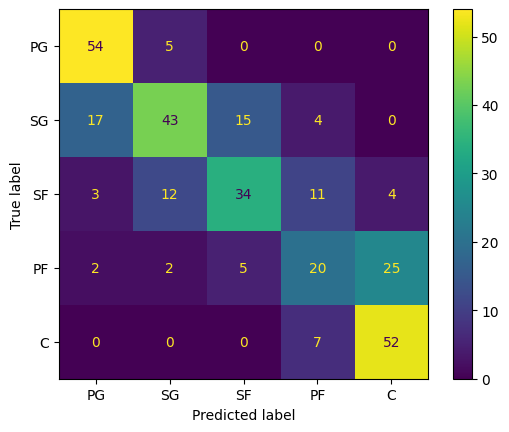

In [29]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(old_y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [30]:
accuracy = accuracy_score(old_y_test, y_pred)
accuracy

0.6444444444444445

In [31]:
print(classification_report(old_y_test, y_pred))

              precision    recall  f1-score   support

           C       0.64      0.88      0.74        59
          PF       0.48      0.37      0.42        54
          PG       0.71      0.92      0.80        59
          SF       0.63      0.53      0.58        64
          SG       0.69      0.54      0.61        79

    accuracy                           0.64       315
   macro avg       0.63      0.65      0.63       315
weighted avg       0.64      0.64      0.63       315



## Visualize trees from random forest with Graphviz

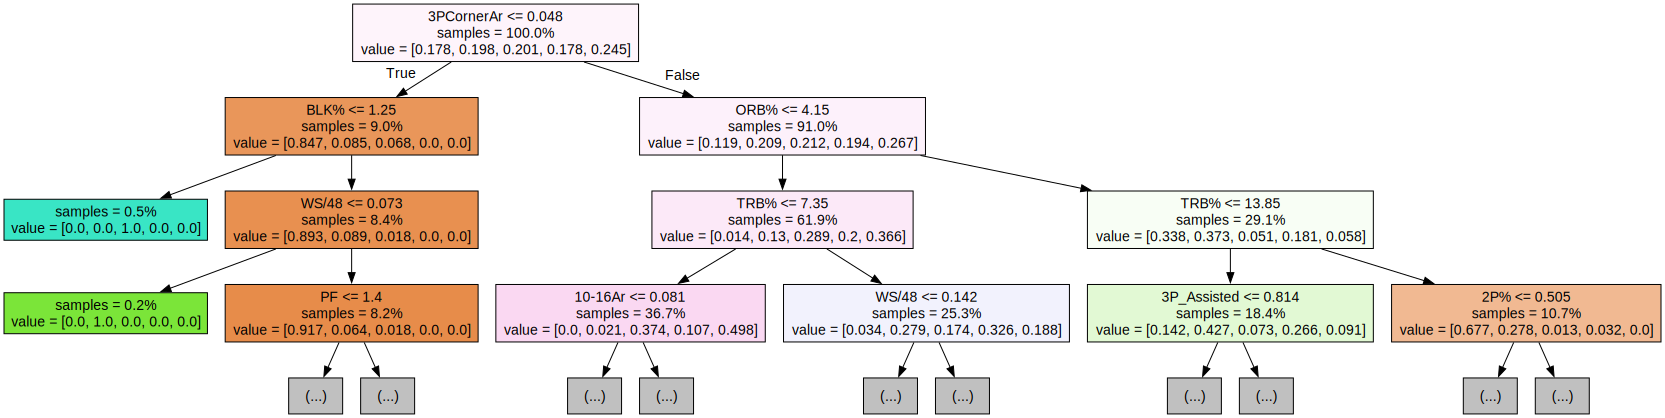

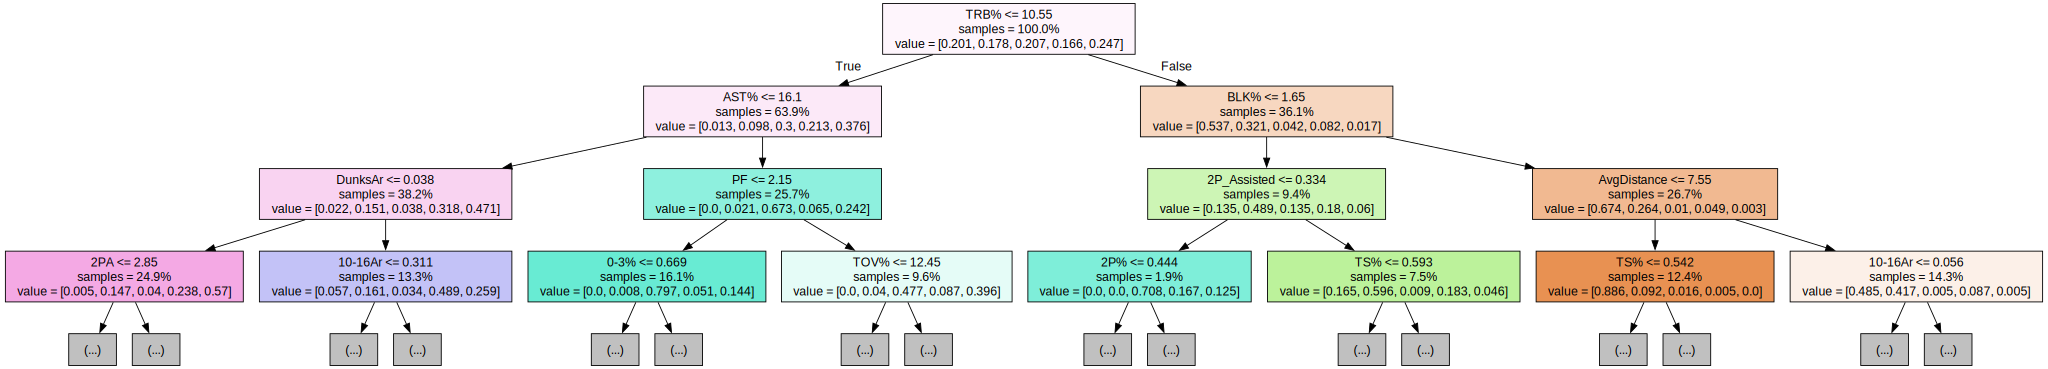

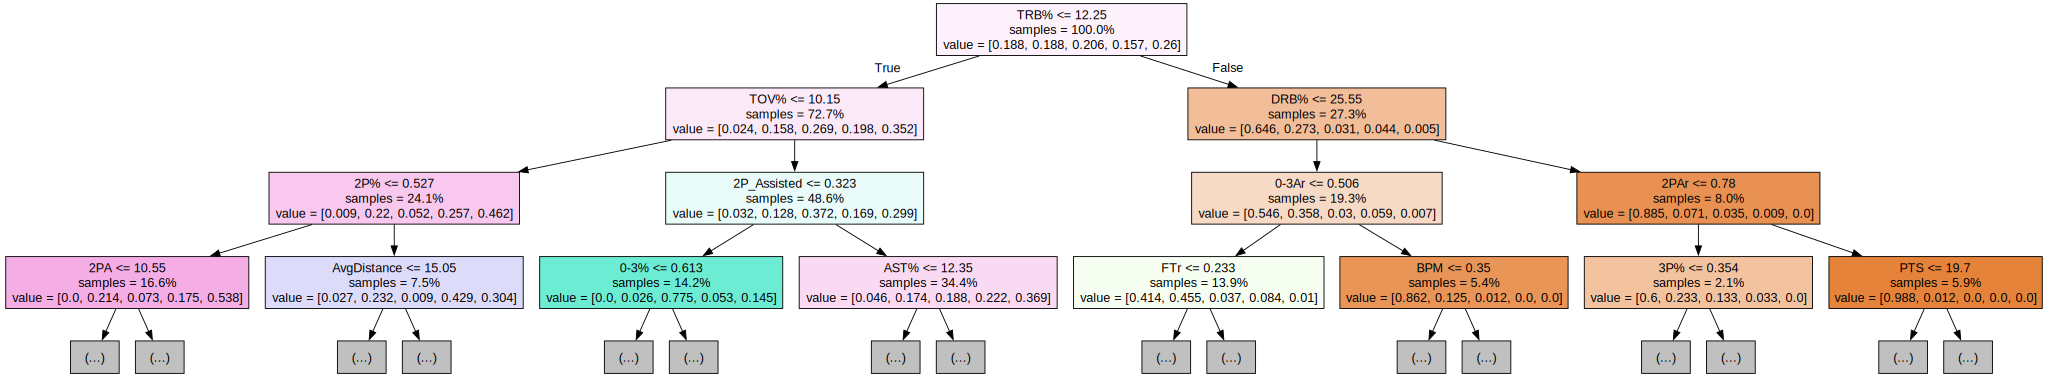

In [32]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, but training with old seasons and predicting recent ones

## Randomly select better parameters for Random Forest and fit the data

In [33]:
rf = random_forest_classify(old_X_train, old_y_train)

In [34]:
y_pred = rf.predict(X_test)

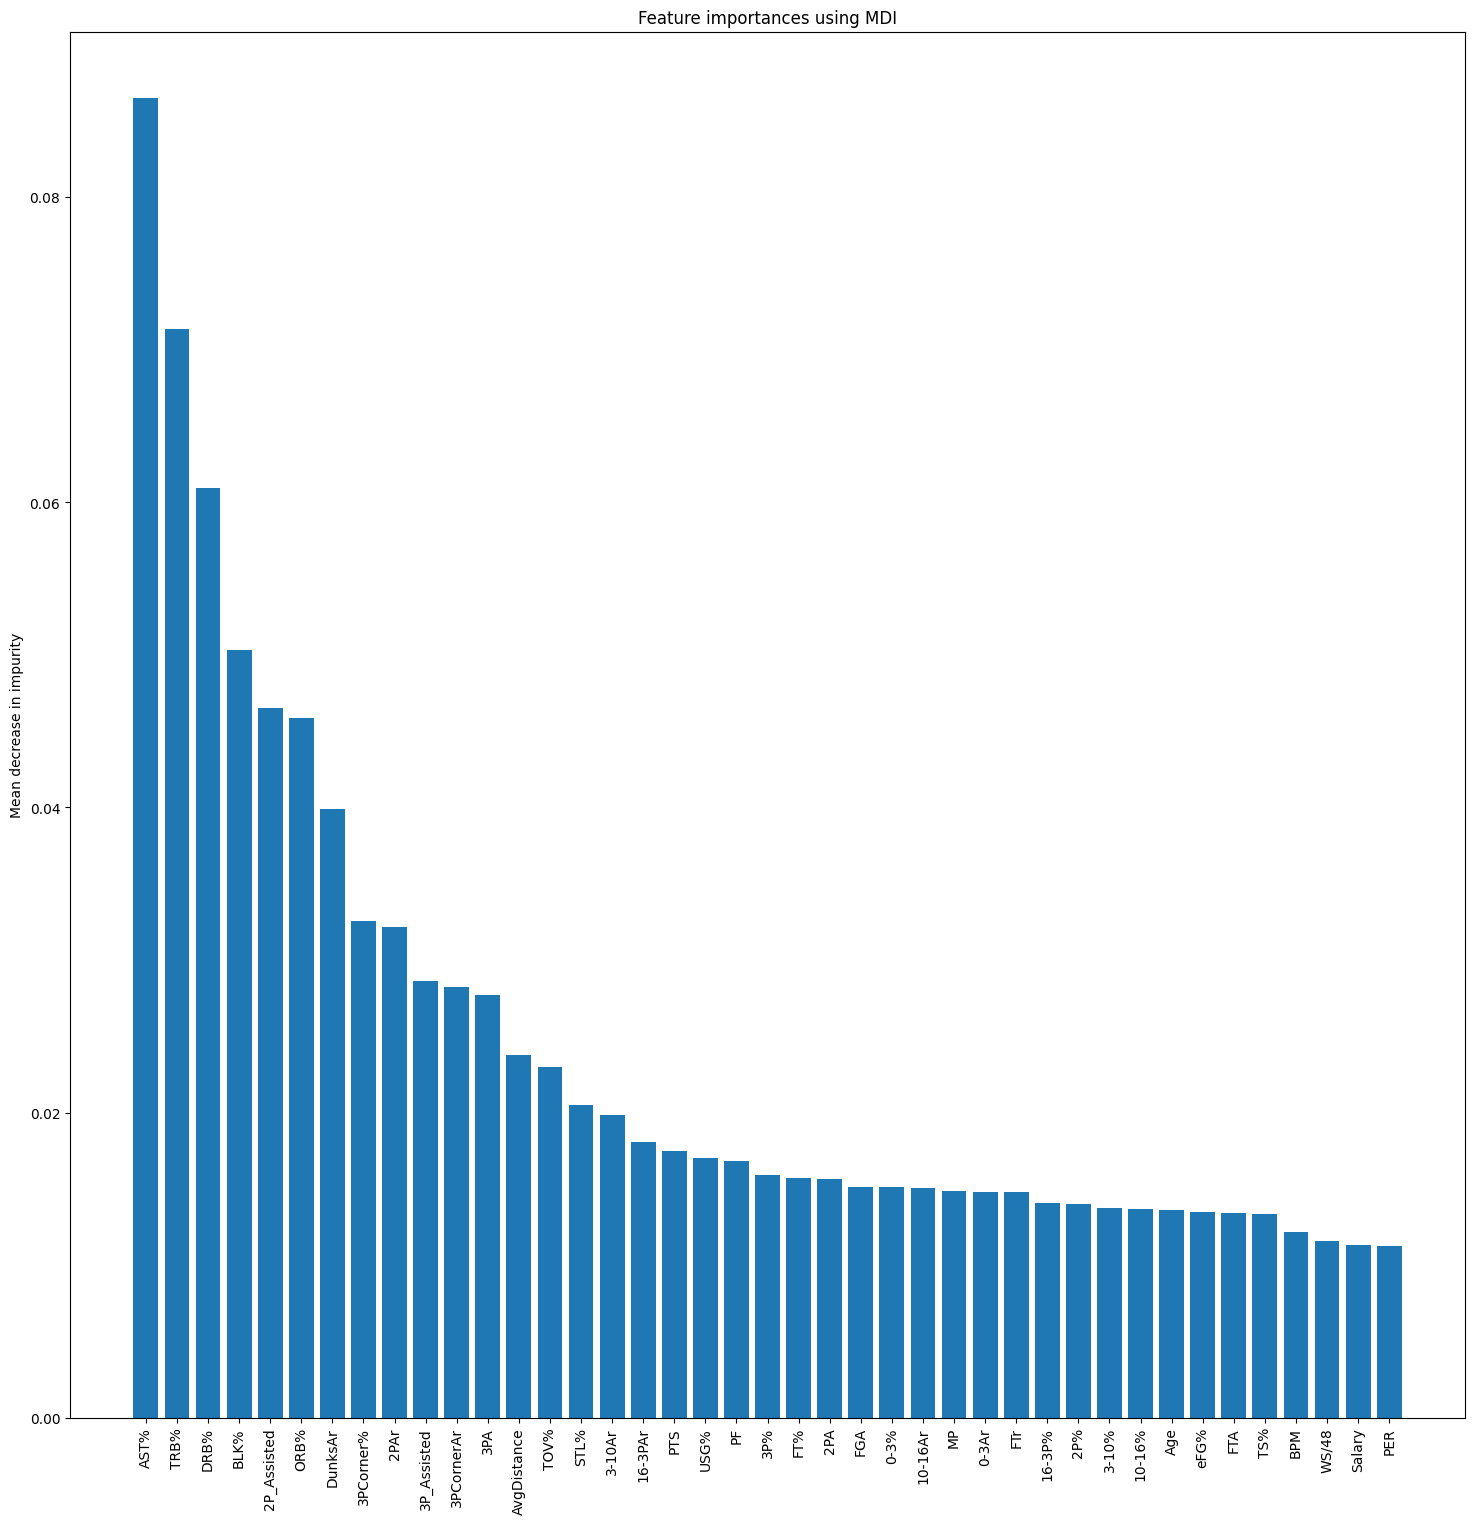

In [35]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in df.columns if c not in ['Player', 'Pos', 'Tm']])

## Evaluating Random Forest results with Confusion Matrix and accuracy score

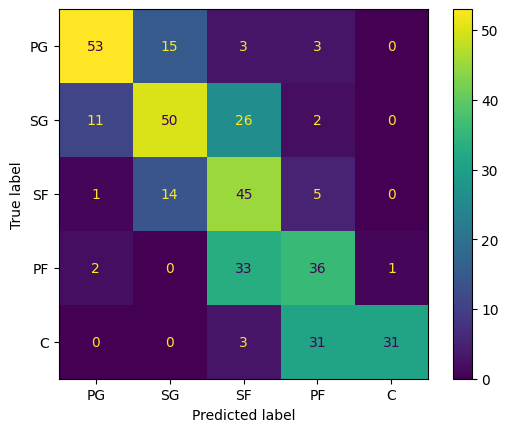

In [36]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [37]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.589041095890411

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.97      0.48      0.64        65
          PF       0.47      0.50      0.48        72
          PG       0.79      0.72      0.75        74
          SF       0.41      0.69      0.51        65
          SG       0.63      0.56      0.60        89

    accuracy                           0.59       365
   macro avg       0.65      0.59      0.60       365
weighted avg       0.65      0.59      0.60       365



## Visualize trees from random forest with Graphviz

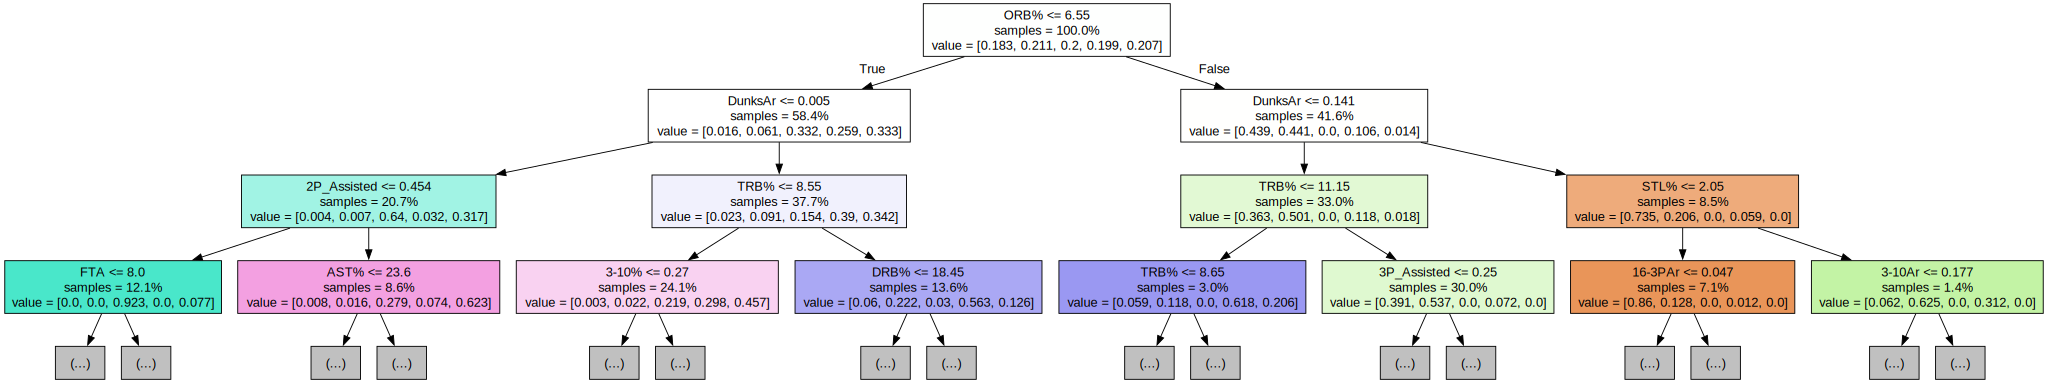

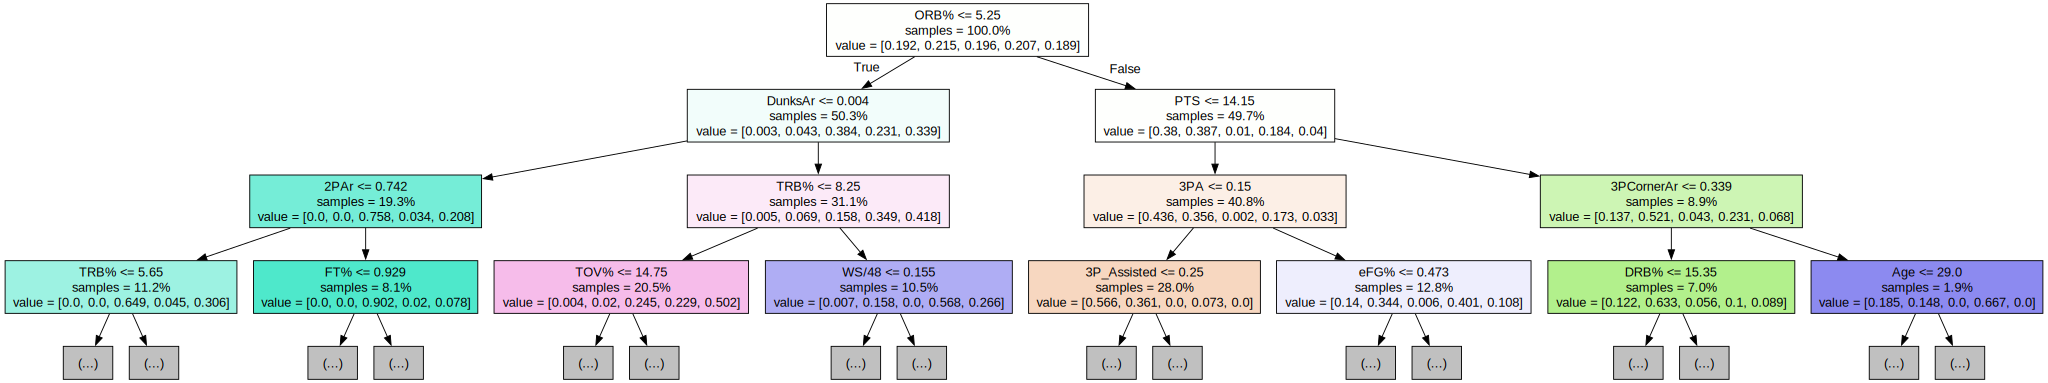

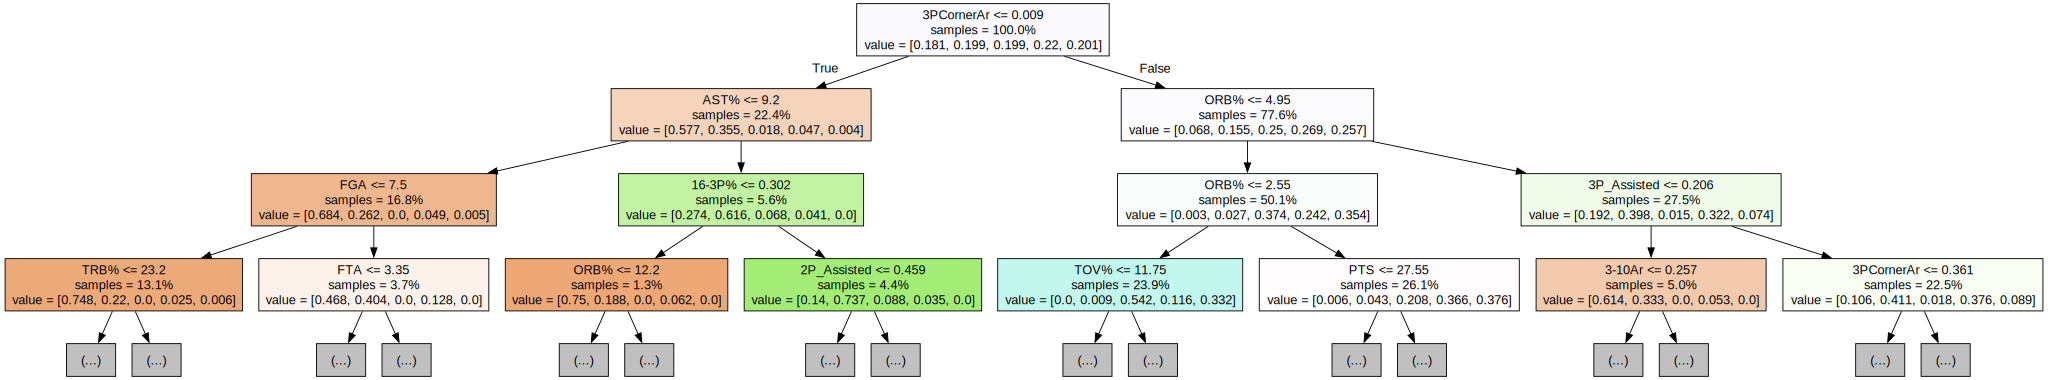

In [39]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Repeat the random forest process, with the first seasons with the 3-point line

In [40]:
first_dfs = []

In [41]:
for season in range(1980,1986):
    first_year, second_year = format_season(season)
    player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")    
    player_data = player_data.fillna(0)
    player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
    player_data = player_data.sort_values(by=['G'], ascending=False)
    player_data = player_data[player_data["Tm"] != "TOT"]
    player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
    player_data.reset_index(inplace=True)
    player_data.drop(columns=['index'], inplace=True)
    
    first_dfs.append(player_data)

In [42]:
first_df = first_dfs[0]
for i in range(1, len(first_dfs)):
    first_df = pd.concat([first_df, first_dfs[i]])
    
first_df.reset_index(inplace=True)
first_df.drop('index', axis=1, inplace=True)

In [46]:
first_df = pre_process(range(1980, 1988))

## Splitting into training/testing

In [47]:
features = first_df.loc[:, ~first_df.columns.isin(["Player", "Pos", "Tm"])]
target = first_df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

## Randomly select better parameters for Random Forest and fit the data

In [48]:
rf = random_forest_classify(X_train, y_train)

In [49]:
y_pred = rf.predict(X_test)

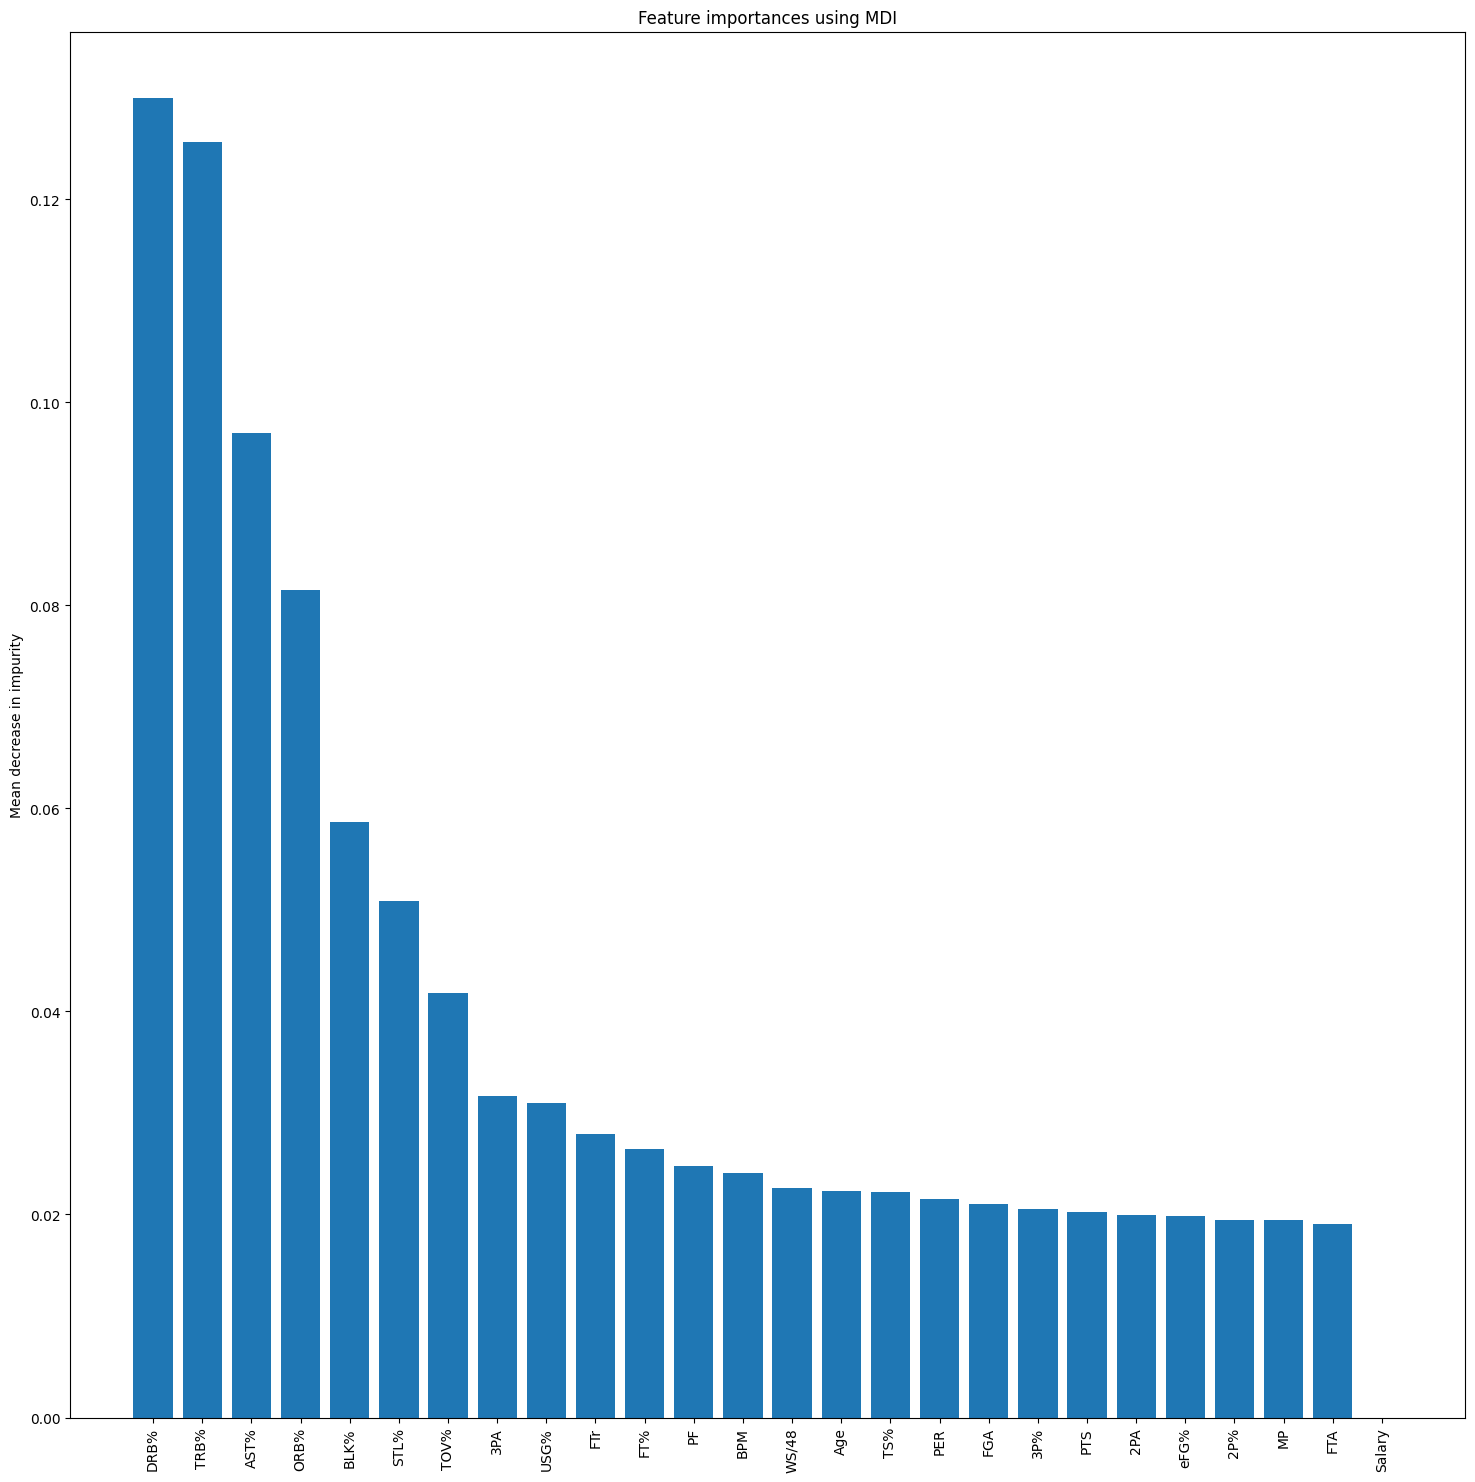

In [50]:
plot_feature_importances(rf.feature_importances_, rf.estimators_, [c for c in first_df.columns if c not in ['Player', 'Pos', 'Tm']])

## Evaluating Random Forest results with Confusion Matrix and accuracy score

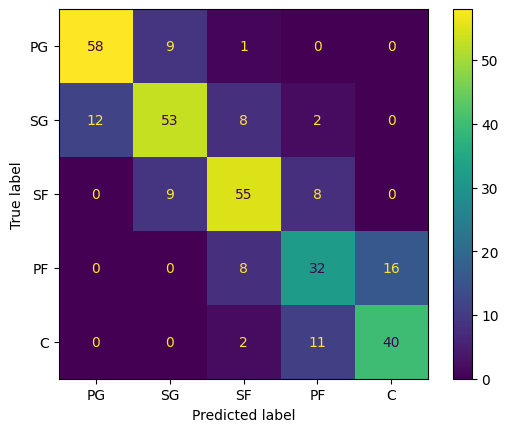

In [51]:
labels = ["PG", "SG", "SF", "PF", "C"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [52]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7345679012345679

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.71      0.75      0.73        53
          PF       0.60      0.57      0.59        56
          PG       0.83      0.85      0.84        68
          SF       0.74      0.76      0.75        72
          SG       0.75      0.71      0.73        75

    accuracy                           0.73       324
   macro avg       0.73      0.73      0.73       324
weighted avg       0.73      0.73      0.73       324



## Visualize trees from random forest with Graphviz

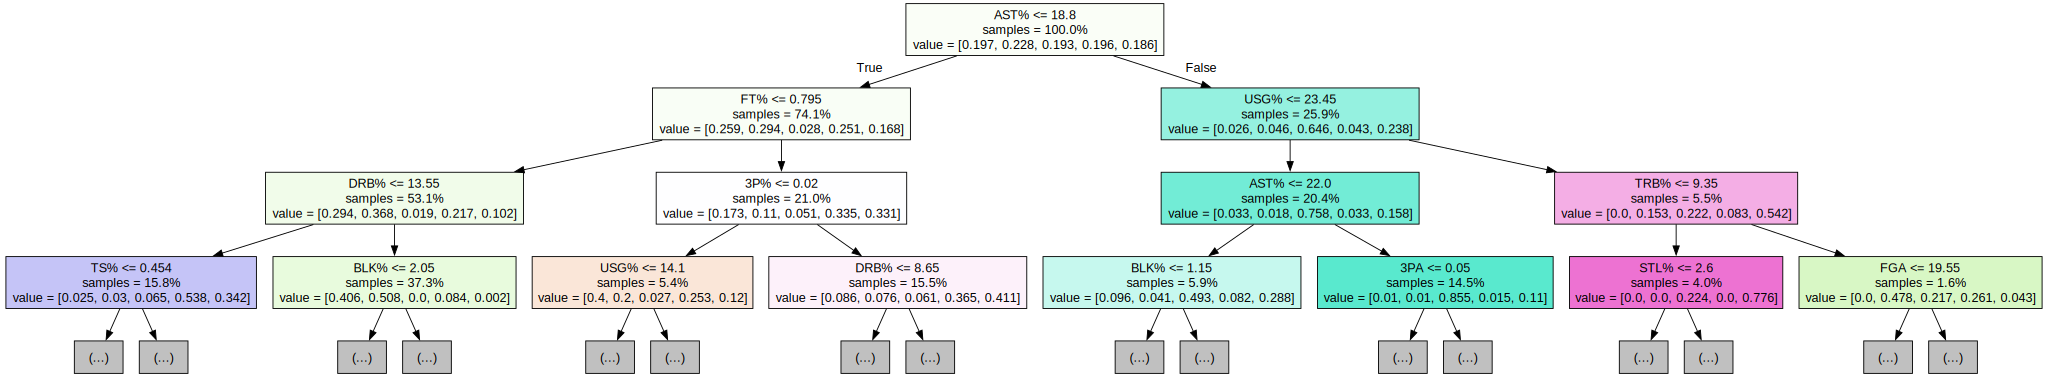

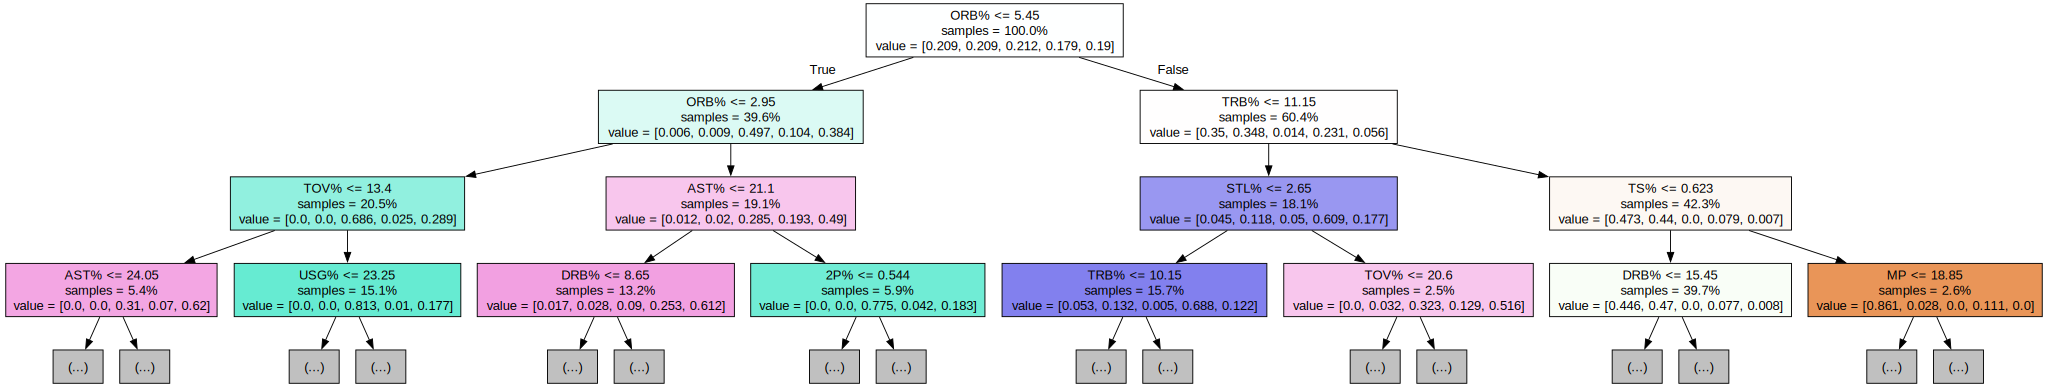

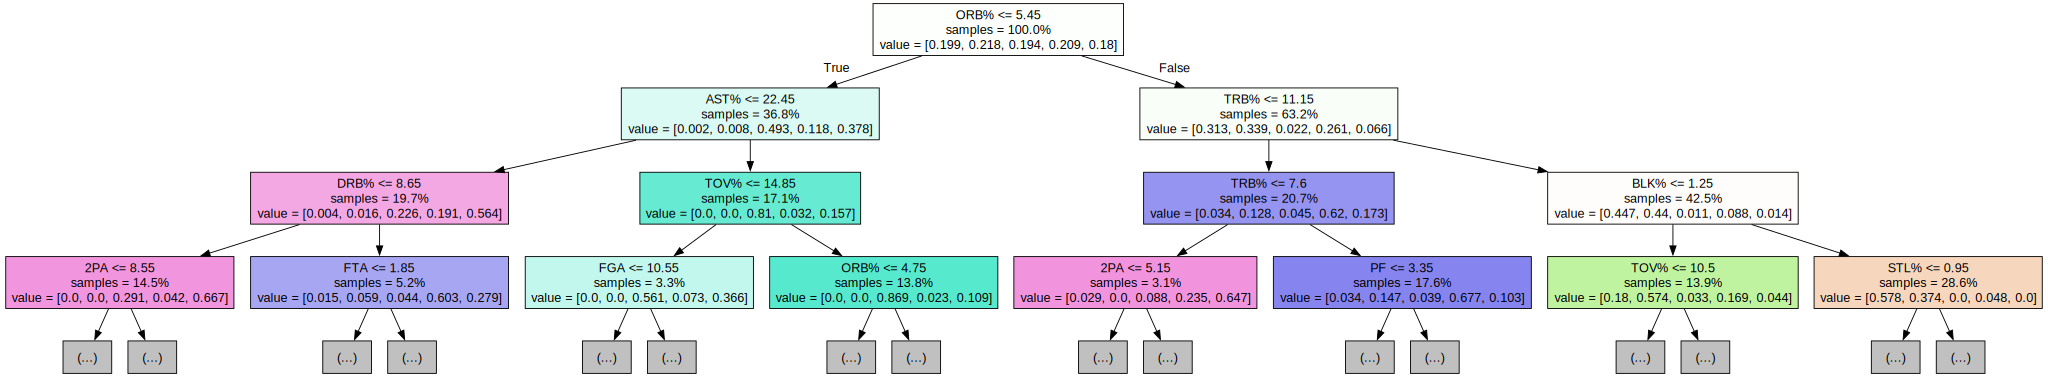

In [54]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)